This notebook reads in a selected region of SLCs, creates interferograms with them, and outputs the igram as an ISCE-readable file for using with SNAPHU. 


This notebook:
1. Reads in two SLCs to plot one and define a subregion to extract for full resolution unwrapping with SNAPHU
2. Reads in just the subregion
3. Creates an interferogram with it
4. Plots it once just to make sure (comment this out later)
5. Saves the subregion+full res igram as an ISCE-readable file.

This notebook was written on 10-10-22

***

Import the things we need.

In [1]:
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
%matplotlib  widget

Set the working directory and define dimensions of the SLC files we'll be loading in

In [2]:
workdir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
outputdir = str(workdir+'cropped_northern_shore_LS_for_unwrapping/')

# size of full res SLCs
dxIN=18000
dyIN=3600

Load in the dates of the SLCs for loading them.

In [3]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)

Read in 2 SLCs for choosing the small region to extract for full res unwrapping with SNAPHU.

In [4]:
# define the dates. 
date1='20191021'
date2='20191027'

In [5]:
# Read in 2 full SLCs to make interferogram 
ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
print('SLC 1 loaded.')
ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
print('SLC 2 loaded.')

SLC 1 loaded.
SLC 2 loaded.


Try a bounding box, plot it with the next cell, then can edit the box. 

In [6]:
# make a bounding box to figure out the region to extract 
box = np.zeros((5,2))
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]
box[4] = box[0]

Plot the SLC magnitudes and the bounding box to choose a region to extract.

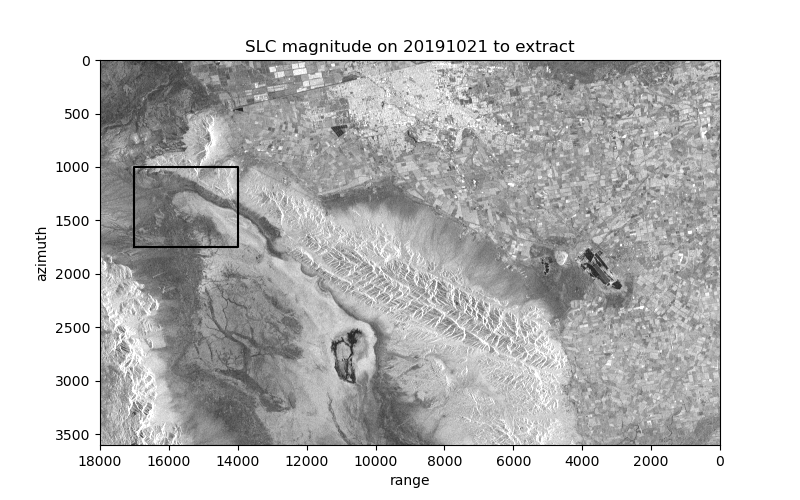

In [7]:
my_vmin = 1
my_vmax = 2.2

plt.figure(figsize=(8,5))
plt.imshow(np.log10(np.abs(slc1)), vmin=my_vmin, vmax=my_vmax, cmap='gray', aspect='auto')
plt.plot(box[:,0],box[:,1],'k-')
plt.xlim(np.shape(slc1)[1], 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('SLC magnitude on '+str(date1)+' to extract')
plt.show()

Set the output dimensions of the files we will write, based on the box defined above. 

In [8]:
dxOUT = int(np.abs(x1-x2))
dyOUT = int(np.abs(y1-y2))

print('range: '+str(dxOUT))
print('azimuth: '+str(dyOUT))
print('total number of pixels: '+str(dxOUT*dyOUT))

range: 3000
azimuth: 750
total number of pixels: 2250000


In [9]:
# read in two SLCs (loop through them later), make igram, output it as a file

# set the driver first, only do once. IS THIS RIGHT?
driver=gdal.GetDriverByName('ISCE')

for i in range(1): #use range(nd-1) when looping through them all. just testing for now.
    date1=dates[i]
    date2=dates[i+1]
    ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    print('SLC 1 subsect loaded.')
    ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    print('SLC 2 subsect loaded.')
    intTemp = np.angle(slc1*np.conj(slc2))
    # save the file 
    colds = driver.Create(outputdir+'igramTemp.r4',dxOUT,dyOUT,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(intTemp)
    colds=None

    # will have to use SNAPHU to unwrap the igram file in this loop so the int file can be re-written
    # so that I don't have to save 210 igram files before unwrapping 

    # output file after unwrapping can be: 
    # filename = str(date1+'-'+date2+'_unwr.r4')
    # colds = driver.Create(outputdir+filename,dxOUT,dyOUT,1,gdal.GDT_Float32)

SLC 1 subsect loaded.
SLC 2 subsect loaded.


Read in the file I just saved above and plot it to make sure I extracted the right thing. 

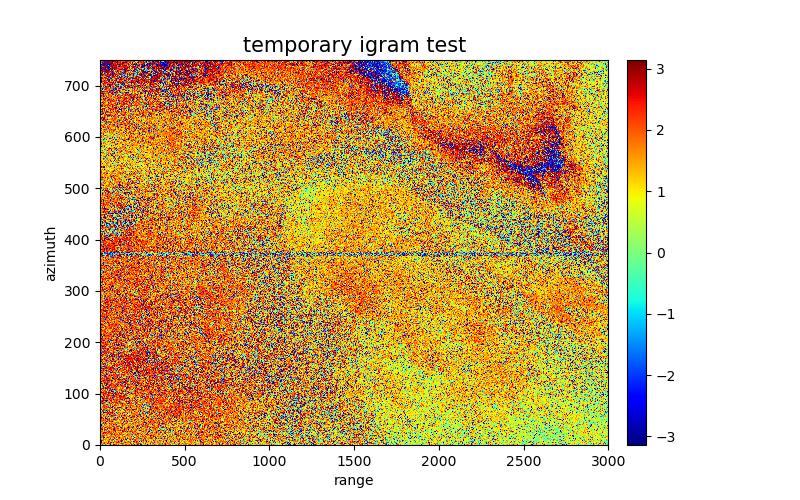

In [10]:
# Now that I've tested one, load in the file and plot it. 
f1 = gdal.Open(outputdir+'igramTemp.r4', gdal.GA_ReadOnly)
igramLoaded = f1.ReadAsArray()
f1 = None

# now plot it
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(igramLoaded)))
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('temporary igram test',fontsize=15)
plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()

Looks good! 

In [11]:
# output a string for what I will want the SNAPHU output (unwrapped) file to be named. 
#outfile = str(date1+'_'+date2+'_unwr.r4')
outfile = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/20191021_20191027_unwr.int'
print(outfile)
# can copy that when running SNAPHU 

/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/20191021_20191027_unwr.int


In [12]:
# load in unwrapped file and plot it to be sure SNAPHU worked. 
#f1 = gdal.Open((outputdir+'20191021_20191027_unwr.r4'), gdal.GA_ReadOnly)
f1 = gdal.Open((outfile), gdal.GA_ReadOnly)
unwr_igram = f1.ReadAsArray()
f1 = None

ERROR 4: /data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/20191021_20191027_unwr.int: No such file or directory


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [ ]:
# now plot it
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(unwr_igram)))
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('temporary igram test',fontsize=15)
plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()